# E12.프로젝트 : CIFAR-10 이미지 생성하기

`18 FEB 2021`

-------------

- 목차
> 0. 작업환경 구성하기   
> 1. 데이터셋 구성하기   
> 2. 생성자 모델 구현하기   
> 3. 판별자 모델 구현하기   
> 4. 손실함수와 최적화 함수 구현하기   
> 5. 훈련과정 상세 기능 구현하기   
> 6. 학습 과정 진행하기   
> 7. (optional) GAN 훈련 과정 개선하기   



GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.





### STEP 0. 작업환경 구성하기
다음과 같이 작업환경을 구성합시다.

In [ ]:
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples   
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints   
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history   

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


### STEP 1. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다

학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
로드한 학습 데이터를 시각화
tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성


CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

CIFAR-10 데이터셋 또한 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가집니다. 한번 확인해 보시죠!

In [3]:
# pixel 값 확인해보기 
print("max pixel:", train_x.max()) 
print("min pixel:", train_x.min()) 

max pixel: 255
min pixel: 0


max값과 min값이 예상하던 대로 출력되었네요.

이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.



In [4]:
#학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### 정규화 시키는 이유? ( Normalization in geneartor and discrminator)

GAN은 생성자와 판별자간의 불균형한 경쟁이 존재하여 노이즈가 매우 심해진다. 이에 대하여 정규화를 진행하게 되는데 BatchNormalization이 아닌 다양한 정규화 방식을 사용한다.

  

  - Equalized Learning rate : 기존 가중치를 초기화 할때 0에서 1사이 값으로 조정하고 학습과정에서 가중치의 매개변수를 정규화한다. kernel initializer가 제안되었고 각 옵티마이저에 대해서 그레디언트 값을 정규화 해준다.

여기서 중요한 개념은 dynamic range를 갖게 되므로 동일한 학습속도를 보장할 수 있다는 점이다.


  - Pixelwise feature vector normalization in generator : 생성자와 판별자 사이에서 계산한 값들의 폭주가 일어나지 않기 위해 픽셀 단위로 정규화를 진행해준다.


In [5]:
# data shape 확인 
train_x.shape

(50000, 32, 32, 3)

학습데이터 32x32, 컬러 이미지 50,000개 확인 

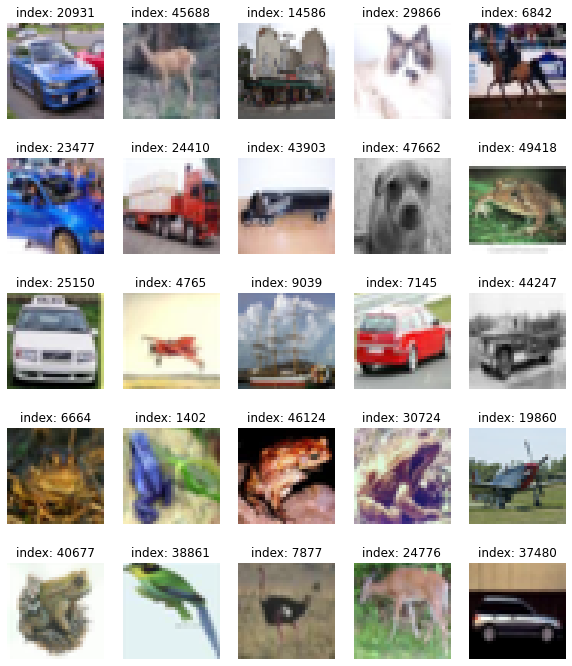

In [6]:
# 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index].reshape(32, 32, 3) + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000으로 설정합니다. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.

BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다. 너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 미니배치 학습 이라고 합니다.

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [8]:
#tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.



## STEP 2. 생성자 모델 구현하기


- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.


GAN의 모델 구조를 알아보았으니, 바로 코드로 모델을 어떻게 구현할 수 있는지 확인해 봅시다!

GAN에는 **생성자, 판별자 모델** 두 개가 있습니다.

오늘 우리가 구현해 볼 모델은 이전 스텝에서 언급했던 `DCGAN(Deep Convolutional GAN)`입니다. 

DCGAN은 GAN의 개념이 처음 소개된 1년 반 이후 발표된 논문으로서, 이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성을 이루어낸 첫 번째 논문으로 평가받고 있습니다. 이후 발표된 수많은 GAN 기반 이미지 생성모델들은 대부분 DCGAN 모델을 발전시킨 형태라고 할 수 있으므로, 그 구조를 상세히 살펴보고 구현 연습을 해보는 것은 매우 의미 있다고 생각됩니다.

모델의 구현은 Keras Sequential API를 활용하겠습니다. 
이후 소개하는 코드는 Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반으로 상세한 설명을 추가하였습니다.

In [9]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
#생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
#노이즈 벡터
noise = tf.random.normal([1, 100])

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

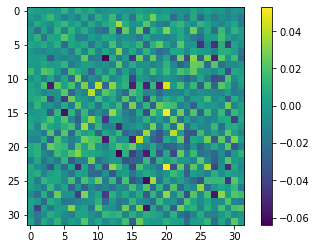

In [13]:
plt.imshow(generated_image[0, :, :, 2])
plt.colorbar()
plt.show()

### STEP 3. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.


In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
# 모델 세부 내용 summmary 출력 
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00209289]], dtype=float32)>

### STEP 4. 손실함수와 최적화함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 5. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.


In [24]:

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 미니배치

- Increasing variation using minibatch standard deviation

GAN은 보통 훈련데이터로부터 일부분을 추출하여 학습하는 경향이 있다. 

여기서 학습하는 방식에 대해서 minibatch discrimination을 이용한다. 

이 방식은 각 레이어의 특징을 추출하여 계산할 뿐만 아니라 미니배치 방식을 적용하기 때문에 유사성을 예측할 수 있다. 구현 방식은 판별자 레이어의 끝에서 미니배치 층을 구현하는 방식이며, 이 층은 큰 텐서형태로 이루어져 있으며 입력값을 투영시킨 결과를 나타낼 수 있다.


이 층은 새롭게 하이퍼파라미터를 정의할 필요도 없고 배울 매개변수도 없다. 처음 우리는 각 미니배치에 대한 표준편차를 구현해야한다. 그런 다음 각 층에 대해 평균을 추정하고 스칼라 값으로 결과를 유도한다. 


In [41]:
# 생성한 이미지 시각화 
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [42]:
# 시각화 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [43]:

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### STEP 6. 학습 과정 진행하기
- STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

In [44]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [45]:
save_every = 5
EPOCHS = 50
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

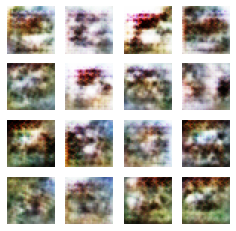

Time for training : 537 sec


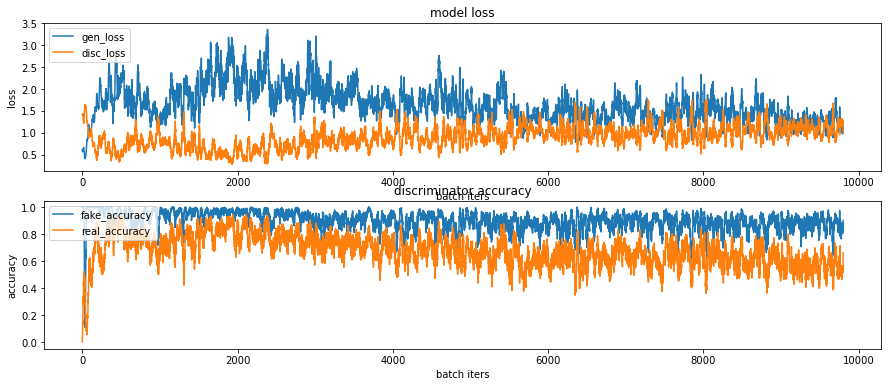

CPU times: user 8min 56s, sys: 21.6 s, total: 9min 18s
Wall time: 8min 57s


In [46]:
%%time
train(train_dataset, EPOCHS, save_every)

In [47]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/animal_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

ls: cannot access '/home/ssac17/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif': No such file or directory


### STEP 7. (optional) GAN 훈련 과정 개선하기
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.

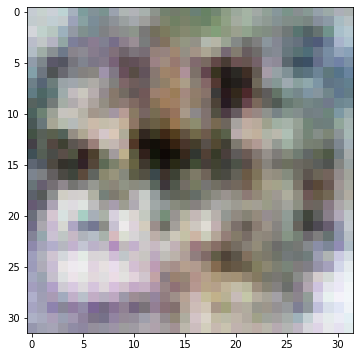

In [48]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [49]:

save_every = 5
EPOCHS = 100

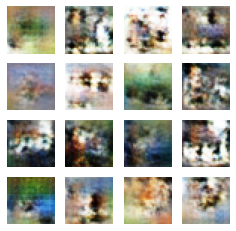

Time for training : 1177 sec


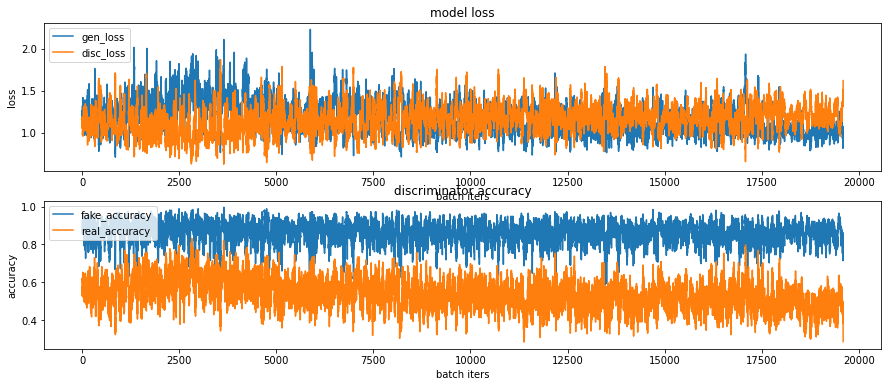

CPU times: user 19min 44s, sys: 40.2 s, total: 20min 25s
Wall time: 19min 38s


In [50]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [51]:
#학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/cifar10_dcgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif

ls: cannot access '/home/ssac17/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif': No such file or directory


# 회고

### 어려움

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다. 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다. 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

- 처음에 아무생각 없이 노드를 진행하다가 중간에 계속 shape이 안맞다는 오류가 나서 곰곰히 생각해보다가 바보같은 실수를,,, 다른분 질문에 내갘ㅋㅋㅋㅋ 이미지 데이터 shape 바꿔주셔야 한다고 알려드렸는데 ㅎ.. 꼼꼼히 읽어보고 막 노드 진행하는 버릇을 고쳐야겠다.

- GAN은 없는 새로운 이미지를 만든다. 학습데이터가 많으면 더 진짜 같은 결과가 나온다. 유투브에서 봤는데 미래의 핸드폰, 노트북과 같은 것을 예측 해놓은 것을 보았는데 신기했다. 워낙 요즘엔 저작권에 관련해 예민하다보니 정말 필요한 부분 같다. 미리 예측하고 관련해서 부족한 부분을 보완하거나 더 나은 방향으로 이끌 수 있도록 도움을 받을 수 있을 것 같다. 

- GAN은 아직 어렵다.. 결과가 매우 흐리게 나왔는데 여러가지 파라미터를 조절해보고 레이어층에도 더 다양하게 바꿔봐야했었는데 시간이 부족해 그러지 못했다. 주말에 노드를 다시한번 보면서 복습을 해야겠다. 

`Multi - Scale Statistical Similarity for assessing GAN Result` 우연히 이논문을 쉽게 풀어놓은 글을 보았는데 확실히 하나의 생성이미지 가지고 데이터셋을 비교하는 것보다 다양한 이미지 크기를 가지고 비교하는 방식인데 흥미로웠다! 

- -> Progressive Growing GAN (PG- GAN)
: 저수준 차원이 이미지를 교육하여 고수준까지 끌어올린다고 기술. 이미지를 시각화하여 다음 네트워크에 층을 추가하여 점진적으로 해상도를 높이는 방식이다. 점진적 특성은 주로 구조(특징)을 파악하면서 다음 계층에서 특징이 점점 세부화 되면서 모든 스케일에 특징이 담겨지게 된다. => 쉽게 생각하면 이말이다. 저 차원에서부터 시작하게 되면 미리 고차원의 구조를 알 수 있다는 말이 된다. 





# `GAN` 

1. generator[생성자] 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑합니다.

2. discriminator[판별자] 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑합니다.

3. 생성자와 판별자를 연결하는 gan 네트워크를 만듭니다. gan(x) = discriminator(generator(x)) 입니다. 이 gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑합니다. 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가합니다.

4. “진짜"/”가짜" 레이블과 함께 !진짜 이미지와 가짜 이미지 샘플을 사용해 "판별자"를 훈련!합니다. 일반적인 이미지 분류 모델을 훈련하는 것과 동일합니다.

5. 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용합니다. 이 말은 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 “진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻입니다. 다른 말로하면 판별자를 속이도록 생성자를 훈련합니다.



### 훈련방법

모든 문제에 반드시 적용해야 것은 아니지만 경험상 잘 작동한다고 알려져 있습니다.

다음은 이 절에서 GAN 생성자와 판별자를 구현하는 데 사용할 몇 가지 기법입니다. 이 목록이 GAN에 관련된 전체 팁이 아닙니다. GAN 논문들에서 더 많은 방법을 볼 수 있습니다.

(구현 할때도 인지하고 있어야 하는 부분이니 꼼꼼히 읽어보세요)


* 생성자의 마지막 활성화로 다른 종류의 모델에서 널리 사용하는 sigmoid 대신 tanh 함수를 사용합니다.(시그 0~ 1 / 아크탄 - 1~1)

* 균등 분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링합니다.

* 무작위성은 모델을 견고하게 만듭니다. GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 가능성이 높습니다. 훈련하는 동안 무작위성을 주입하면 이를 방지하는 데 도움이 됩니다. 무작위성은 두 가지 방법으로 주입합니다. 판별자에 드롭아웃을 사용하거나 판별자를 위해 레이블에 랜덤 노이즈를 추가합니다.

*희소한 그래디언트는 GAN 훈련을 방해할 수 있습니다. 딥러닝에서 희소는 종종 바람직한 현상이지만 GAN에서는 그렇지 않습니다. 그래디언트를 희소하게 만들 수 있는 것은 최대 풀링 연산과 ReLU 활성화 두 가지입니다. 

==>최대 풀링 대신 스트라이드 합성곱을 사용해 다운샘플링​을 하는 것이 좋습니다. 또 ReLU 활성화 대신 LeakyReLU 층을 사용하세요. ReLU와 비슷하지만 음수의 활성화 값을 조금 허용하기 때문에 희소가 조금 완화됩니다.

*생성자에서 픽셀 공간을 균일하게 다루지 못해 생성된 이미지에서 체스판 모양이 종종 나타납니다(그림 8-17 참조). 이를 해결하기 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기를 사용합니다.



### 생성자(generator)

먼저 벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링됩니다)를 후보 이미지로 변환하는 generator 모델을 만들어 보죠. GAN에서 발생하는 많은 문제 중 하나는 생성자가 노이즈 같은 이미지를 생성하는 데서 멈추는 것입니다. 판별자와 생성자 양쪽에 모두 드롭아웃을 사용하는 것이 해결 방법이 될 수 있습니다.



### 판별자(discriminator)

다음은 후보 이미지(진짜 혹은 가짜)를 입력으로 받고 두 개의 클래스로 분류하는 discriminator 모델을 만들겠습니다. 이 클래스는 '생성된 이미지'  또는  '훈련 세트에서 온 진짜 이미지'입니다.


### 적대적 네트워크(GAN)


마지막으로 생성자와 판별자를 연결하여 GAN을 설정합니다. 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습합니다. 이 모델은 잠재 공간의 포인트를 “진짜" 또는 “가짜"의 분류 결정으로 변환합니다. 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지 ' 입니다.



'gan을 훈련하는 것'은 discriminator가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 'generator의 가중치'를 업데이트하는 것입니다.



훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요합니다. gan을 훈련할 때 가중치가 업데이트되지 않습니다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 “진짜"를 예측하도록 훈련됩니다. 


### 참고

[[파이썬,python 딥러닝] GAN으로 이미지 생성](https://blog.naver.com/demian7607/222049667265)

[케라스를 이용한 CNN CIFAR-10 이미지 분류 모델 5(정확도: 81.61%)](https://blog.naver.com/qbxlvnf11/221369724614)

[Wasserstein GAN 수학 이해하기 I](https://www.slideshare.net/ssuser7e10e4/wasserstein-gan-i)

[Progressive Growing Generative Adversarial Networks 논문 리뷰](https://blog.naver.com/jonghyeon9587/222204226740)